<a href="https://colab.research.google.com/github/bismillahkani/Practical-Introduction-To-AWS-SageMaker/blob/master/cifar10_classification_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR10 image classification using PyTorch

Based on https://jovian.ml/aakashns/05-cifar10-cnn

### Import libraries

In [1]:
# SageMaker has issues with torch version 1.6.0. Uncomment the below lines and restart runtime to use lower version. 
# !pip install torch==1.4.0 -q
# !pip install torchvision==0.6.0 -q

In [2]:
import os
import tarfile
import torch
import torchvision
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
print(torch.__version__)

1.6.0+cu101


### Dataset

In [4]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

data_dir = './data/cifar10'

dataset = ImageFolder(data_dir+'/train', transform=ToTensor())

random_seed = 42
torch.manual_seed(random_seed);

val_size = 5000
train_size = len(dataset) - val_size

# Split into train and validation dataset
train_ds, val_ds = random_split(dataset, [train_size, val_size])

batch_size=128

# Training and validation dataloaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

### Model

In [5]:
def accuracy(outputs, labels):
  """Model evaluation metrics"""
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
  """Base Image classification class""" 
  def training_step(self, batch):
      images, labels = batch 
      out = self(images)                  # Generate predictions
      loss = F.cross_entropy(out, labels) # Calculate loss
      return loss
  
  def validation_step(self, batch):
      images, labels = batch 
      out = self(images)                    # Generate predictions
      loss = F.cross_entropy(out, labels)   # Calculate loss
      acc = accuracy(out, labels)           # Calculate accuracy
      return {'val_loss': loss.detach(), 'val_acc': acc}
      
  def validation_epoch_end(self, outputs):
      batch_losses = [x['val_loss'] for x in outputs]
      epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
      batch_accs = [x['val_acc'] for x in outputs]
      epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
      return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
  
  def epoch_end(self, epoch, result):
      print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
          epoch, result['train_loss'], result['val_loss'], result['val_acc']))

class Cifar10CnnModel(ImageClassificationBase):
  """cifar10 classfification model"""
  def __init__(self):
      super().__init__()
      self.network = nn.Sequential(
          nn.Conv2d(3, 32, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

          nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

          nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

          nn.Flatten(), 
          nn.Linear(256*4*4, 1024),
          nn.ReLU(),
          nn.Linear(1024, 512),
          nn.ReLU(),
          nn.Linear(512, 10))
      
  def forward(self, xb):
      return self.network(xb)

In [6]:
model = Cifar10CnnModel()

### Helper functions

In [7]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [8]:
device = get_default_device()

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

### Training

In [9]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  """ Training script """
  history = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
      # Training Phase 
      model.train()
      train_losses = []
      for batch in train_loader:
          loss = model.training_step(batch)
          train_losses.append(loss)
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
      # Validation phase
      result = evaluate(model, val_loader)
      result['train_loss'] = torch.stack(train_losses).mean().item()
      model.epoch_end(epoch, result)
      history.append(result)
  return history

In [10]:
model = to_device(Cifar10CnnModel(), device)

num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.7836, val_loss: 1.4507, val_acc: 0.4604
Epoch [1], train_loss: 1.2696, val_loss: 1.1453, val_acc: 0.5862
Epoch [2], train_loss: 1.0294, val_loss: 0.9585, val_acc: 0.6574
Epoch [3], train_loss: 0.8673, val_loss: 0.8742, val_acc: 0.6896
Epoch [4], train_loss: 0.7353, val_loss: 0.8016, val_acc: 0.7206
Epoch [5], train_loss: 0.6355, val_loss: 0.7874, val_acc: 0.7294
Epoch [6], train_loss: 0.5456, val_loss: 0.7279, val_acc: 0.7485
Epoch [7], train_loss: 0.4682, val_loss: 0.7290, val_acc: 0.7614
Epoch [8], train_loss: 0.3885, val_loss: 0.7537, val_acc: 0.7630
Epoch [9], train_loss: 0.3238, val_loss: 0.7953, val_acc: 0.7669


### Save model

In [11]:
# save the model artifacts as .pth file
torch.save(model.state_dict(),'model.pth')

### Load model

In [12]:
# create cifar10 model and load the model weights
model_cifar = to_device(Cifar10CnnModel(), device)
model_cifar.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

### Inference

In [13]:
# test dataset
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

In [14]:
def predict_image(img, model):
  """predict function to predict the image class"""
  # Convert to a batch of 1
  xb = to_device(img.unsqueeze(0), device)
  # Get predictions from model
  yb = model(xb)
  # Pick index with highest probability
  _, preds  = torch.max(yb, dim=1)
  # Retrieve the class label
  return dataset.classes[preds[0].item()]

Label: airplane , Predicted: ship


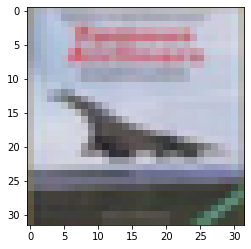

In [15]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_cifar))

### Prepare for deployment in AWS


* After the model is trained, save the model artifcats as 'model.pth'
* Test the model by loading the model artifacts and doing inference
* Once testing is ok, download the 'model.pth' file. 